# 🛍️ Mall Customer Segmentation with K-Means

Bu proje, alışveriş merkezi müşterilerini gelir ve harcama davranışlarına göre segmentlere ayırmak amacıyla geliştirilmiştir.  
Amaç, veri odaklı pazarlama stratejileri geliştirmektir.

<details>
<summary><strong>📌 İçindekiler</strong></summary>
    
- Veri Seti Tanıtımı
- Keşifsel Veri Analizi (EDA)
- Veri Hazırlama
- Görselleştirme Analizi
- Optimal Küme Sayısı
- K-Means Kümeleme
- Segment Profilleri
- İş Stratejileri ve Sonuç
</details>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python 
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/customer-segmentation-tutorial-in-python/Mall_Customers.csv


In [2]:
# Veri işleme ve sayısal işlemler
import numpy as np
import pandas as pd

# Görselleştirme
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.offline as py

# Makine öğrenmesi
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# Uyarıları gizle
import warnings
warnings.filterwarnings("ignore")

# Plotly notebook modu
py.init_notebook_mode(connected=True)

print("Kütüphaneler yüklendi ✅")


Kütüphaneler yüklendi ✅


## 📂 Veri Setinin Yüklenmesi ve İlk İnceleme

Bu aşamada müşteri verisi Kaggle ortamından yüklenmiş ve veri setinin genel yapısı incelenmiştir.  
Amaç; sütun yapısını, veri tiplerini, gözlem sayısını ve eksik veri durumunu kontrol ederek
analizin ilerleyen aşamaları için verinin uygunluğunu doğrulamaktır.

In [3]:
# Veri seti yolu (Kaggle)
data_path = "/kaggle/input/customer-segmentation-tutorial-in-python/Mall_Customers.csv"

# Veri setinin yüklenmesi
df = pd.read_csv(data_path)

# İlk 5 gözlemin incelenmesi
df.head()


# Veri setinin genel yapısı
df.info()

# Temel istatistiksel özet
df.describe()

# Eksik değer kontrolü 
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

## 🔍 Keşifsel Veri Analizi (EDA)

Veri seti, bir alışveriş merkezine ait 200 müşterinin demografik ve davranışsal bilgilerini içermektedir. 
Toplam 5 değişken bulunmaktadır: müşteri kimliği, cinsiyet, yaş, yıllık gelir ve harcama skoru.

Yapılan incelemede:
- Eksik (null) veri bulunmadığı,
- Sayısal değişkenlerin mantıklı değer aralıklarında olduğu,
- Kategorik değişken olarak yalnızca `Gender` sütununun yer aldığı görülmüştür.

Temel istatistiklere göre:
- Yaş aralığı 18–70,
- Yıllık gelir 15–137 k$,
- Harcama skoru 1–99 arasında değişmektedir.

📌 **Sonuç:** Veri seti temizdir ve K-Means gibi gözetimsiz öğrenme algoritmaları ile müşteri segmentasyonu yapmak için uygundur.

### 🔍 Değişkenlerin Tanıtımı

Bu veri seti, bir alışveriş merkezine ait müşterilerin demografik ve harcama bilgilerini içermektedir. 
Segmentasyon analizinde aşağıdaki değişkenler kullanılacaktır:

- **CustomerID**: Müşteriye ait benzersiz kimlik numarası
- **Gender**: Müşterinin cinsiyeti (Male / Female)
- **Age**: Müşterinin yaşı
- **Annual Income (k$)**: Müşterinin yıllık geliri (bin dolar cinsinden)
- **Spending Score (1-100)**: Müşterinin harcama eğilimini gösteren skor


<details>
<summary><b><strong>🧹 Aşama 3 – Veri Hazırlama</strong></b></summary>

Bu aşamada kümeleme algoritmasının doğru çalışması için:
- Kimlik bilgileri çıkarılmıştır.
- Kategorik değişkenler sayısallaştırılmıştır.
- Veriler ölçeklendirilmiştir.

</details>


In [4]:
# 🧹 Aşama 3 – Veri Hazırlama

# CustomerID kümeleme için anlamlı değil → çıkarılır
df_model = df.drop(['CustomerID'], axis=1)

# Gender kategorik → sayısallaştırılır
df_model['Gender'] = df_model['Gender'].map({'Male': 0, 'Female': 1})

# Ölçeklendirme
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_model)

df_model.head()

print("Veri hazırlandı ve ölçeklendirildi ✅")


Veri hazırlandı ve ölçeklendirildi ✅


## 📊 Dağılım ve Aykırı Değer Kontrolü

Bu adımda K-Means öncesinde sayısal değişkenlerin dağılımları ve olası aykırı değerler
boxplot ve histogramlar yardımıyla incelenmiştir.
Amaç, veri setinde modeli olumsuz etkileyebilecek uç değerlerin olup olmadığını
gözlemlemektir.

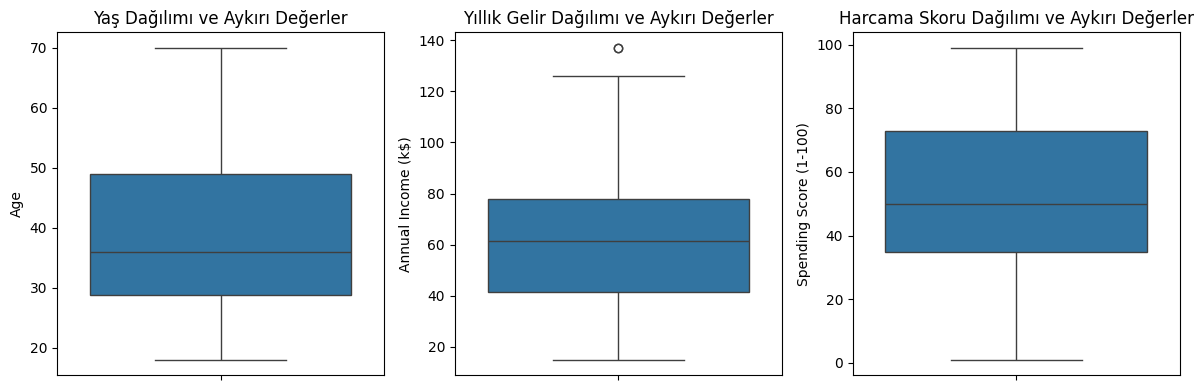

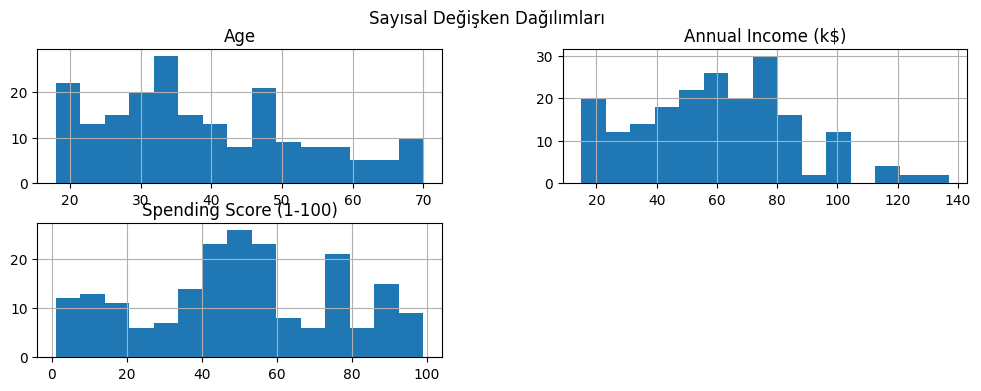

In [5]:
# 📊 Dağılım ve Aykırı Değer Kontrolü

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
sns.boxplot(y=df_model['Age'])
plt.title('Yaş Dağılımı ve Aykırı Değerler')

plt.subplot(1,3,2)
sns.boxplot(y=df_model['Annual Income (k$)'])
plt.title('Yıllık Gelir Dağılımı ve Aykırı Değerler')

plt.subplot(1,3,3)
sns.boxplot(y=df_model['Spending Score (1-100)'])
plt.title('Harcama Skoru Dağılımı ve Aykırı Değerler')

plt.tight_layout()
plt.show()

# Histogramlar
df_model[['Age','Annual Income (k$)','Spending Score (1-100)']] \
    .hist(figsize=(12,4), bins=15)

plt.suptitle('Sayısal Değişken Dağılımları')
plt.show()

## 📊 Veri Görselleştirme Analizi
Histogram grafiklerinde müşterilerin büyük bir kısmının orta yaş
aralığında toplandığı görülmektedir. Yıllık gelir ve harcama skoru
dağılımları, düşük, orta ve yüksek seviyelerde müşteri gruplarının
bulunduğunu göstermektedir.

Yıllık gelir ile harcama skoru arasındaki saçılım grafiği incelendiğinde,
müşterilerin benzer davranışlar etrafında kümelenme eğiliminde olduğu
gözlemlenmiştir.

📌 Sonuç: Görselleştirme çıktıları, müşteri davranışlarının
K-Means kümeleme algoritması ile ayrıştırılabileceğini göstermektedir.

## 3️⃣ Scatter Plot – Değişkenler Arası İlişkiler
Bu bölümde müşterilerin yaş, yıllık gelir ve harcama skoru arasındaki ilişkiler saçılım grafikleri ile incelenmiştir.
Grafiklerde cinsiyet değişkeni renklendirme ile gösterilerek olası davranış farklılıklarının görsel olarak gözlemlenmesi amaçlanmıştır.

## 🔍 Optimal Küme Sayısı – Elbow Method
Bu yöntemde, farklı küme sayıları için toplam hata (inertia) hesaplanır. Dirsek noktasının oluştuğu değer, ideal küme sayısını gösterir.

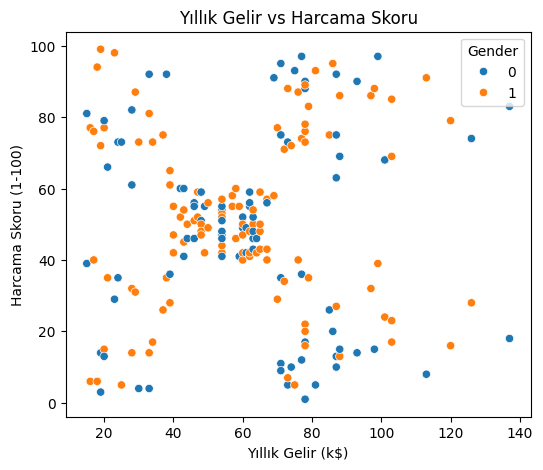

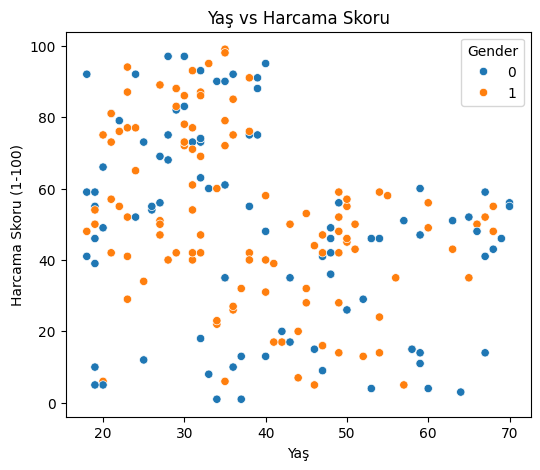

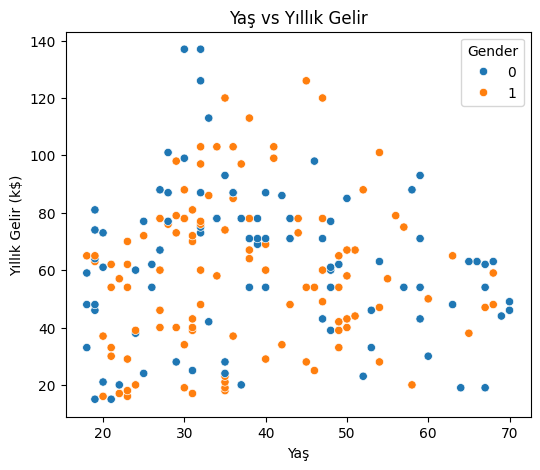

In [6]:
#3️⃣ Scatter Plot – Değişkenler Arası İlişkiler

# 1️⃣ Gelir vs Harcama Skoru
plt.figure(figsize=(6,5))
sns.scatterplot(
    x='Annual Income (k$)',
    y='Spending Score (1-100)',
    hue='Gender',
    data=df_model
)
plt.title('Yıllık Gelir vs Harcama Skoru')
plt.xlabel('Yıllık Gelir (k$)')
plt.ylabel('Harcama Skoru (1-100)')
plt.show()

# 2️⃣ Yaş vs Harcama Skoru
plt.figure(figsize=(6,5))
sns.scatterplot(
    x='Age',
    y='Spending Score (1-100)',
    hue='Gender',
    data=df_model
)
plt.title('Yaş vs Harcama Skoru')
plt.xlabel('Yaş')
plt.ylabel('Harcama Skoru (1-100)')
plt.show()

# 3️⃣ Yaş vs Yıllık Gelir
plt.figure(figsize=(6,5))
sns.scatterplot(
    x='Age',
    y='Annual Income (k$)',
    hue='Gender',
    data=df_model
)
plt.title('Yaş vs Yıllık Gelir')
plt.xlabel('Yaş')
plt.ylabel('Yıllık Gelir (k$)')
plt.show()

📊 Scatter Plot Analizi

Scatter grafikler, müşterilerin yaş, yıllık gelir ve harcama skoru değişkenleri arasında doğrusal olmayan ancak belirgin kümelenme eğilimleri olduğunu göstermektedir. Özellikle yıllık gelir ve harcama skoru arasındaki dağılım, K-Means algoritmasının bu veri seti üzerinde etkili segmentasyon yapabileceğine işaret etmektedir.

Cinsiyet değişkeni renklerle gösterilmiş olsa da, görsel inceleme sonucunda müşteri davranışlarının cinsiyete göre belirgin bir ayrışma göstermediği gözlemlenmiştir.

In [7]:
# 🔹 Silhouette ve Elbow için kullanılacak veri hazırlığı
from sklearn.preprocessing import StandardScaler

X = df[['Annual Income (k$)', 'Spending Score (1-100)']]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## 🔍 Optimal Küme Sayısı – Silhouette Score


Silhouette Score, her bir veri noktasının kendi kümesine ne kadar iyi uyduğunu
ölçen bir metriktir. Değerler -1 ile 1 arasında değişir.

Bu çalışmada elde edilen Silhouette Score değeri, müşteri segmentlerinin
birbirinden anlamlı şekilde ayrıldığını ve K-Means algoritmasının
uygun bir kümeleme gerçekleştirdiğini göstermektedir.

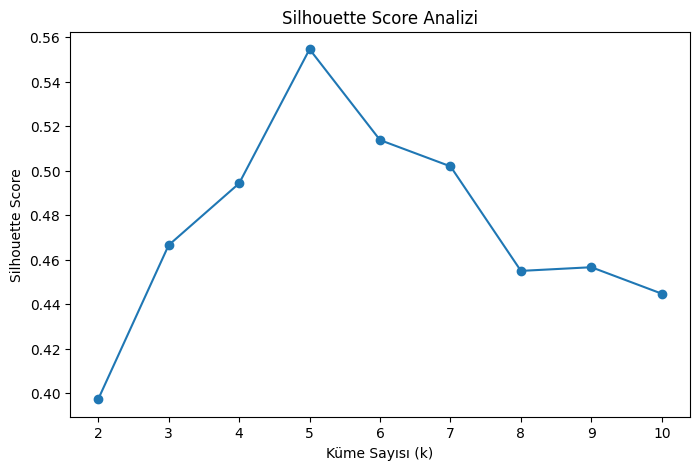

In [8]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Silhouette skorlarını tutacak liste
silhouette_scores = []

# 2'den 10'a kadar farklı küme sayıları denenir
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(score)

# Grafik
plt.figure(figsize=(8,5))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.xlabel('Küme Sayısı (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score Analizi')
plt.show()

📊 Optimal Küme Sayısı – Sonuç

Elbow Method grafiğinde hata değerlerindeki düşüşün k=5 civarında yavaşladığı görülmektedir.
Silhouette Score analizi de k=5 için göreceli olarak yüksek bir değer sunmaktadır.

Bu nedenle müşteri segmentasyonu için **5 küme optimal olarak seçilmiştir.**

## 4️⃣ K-Means Kümeleme ve Scatter Plot
Bu aşamada Elbow Method kullanılarak optimal küme sayısı belirlenmiş, ardından K-Means algoritması uygulanarak müşteri segmentleri oluşturulmuştur. 
Kümeleme işlemi ölçeklenmiş veriler üzerinden gerçekleştirilmiştir.
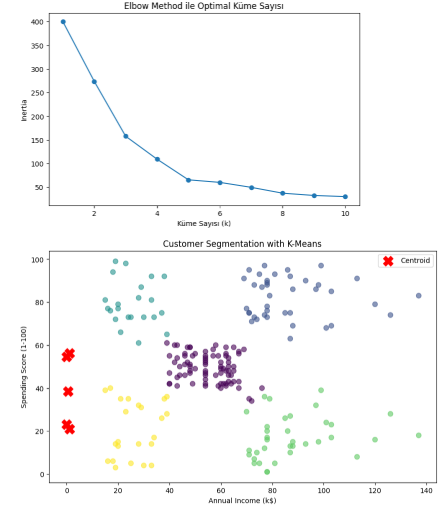

📌 Not: K-Means algoritması ölçeklenmiş veriler üzerinde çalıştırılmıştır.
Ancak görselleştirmelerde, segmentlerin iş birimleri tarafından
daha kolay yorumlanabilmesi için orijinal değişken değerleri kullanılmıştır.

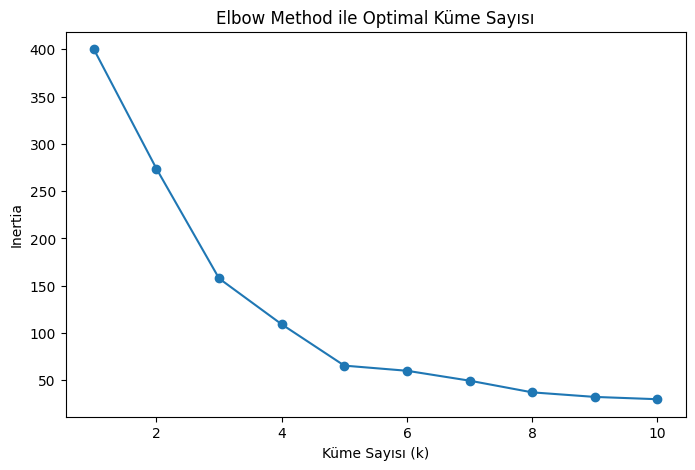

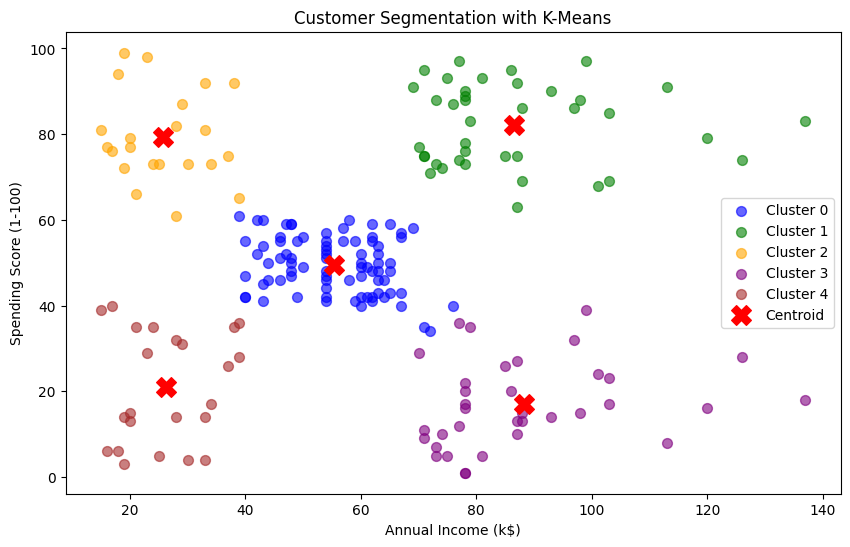

In [9]:
# 📌 4️⃣ K-Means Kümeleme ve Scatter Plot

# ===============================
# 📌 K-MEANS CLUSTERING
# ===============================

# Gerekli kütüphaneler
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# -------------------------------
# 1️⃣ Kümeleme için kullanılacak değişkenler
# (SADECE gelir ve harcama skoru)
# -------------------------------
X = df[['Annual Income (k$)', 'Spending Score (1-100)']]

# Ölçeklendirme
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# -------------------------------
# 2️⃣ Elbow Method
# -------------------------------
inertia = []

for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Küme Sayısı (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method ile Optimal Küme Sayısı')
plt.show()

# -------------------------------
# 3️⃣ Final K-Means Modeli (k=5)
# -------------------------------
kmeans = KMeans(n_clusters=5, random_state=42)
df['Cluster'] = kmeans.fit_predict(X_scaled)

# -------------------------------
# 4️⃣ Orijinal veride centroidler
# -------------------------------
centroids = df.groupby('Cluster')[[
    'Annual Income (k$)', 
    'Spending Score (1-100)'
]].mean().values

# -------------------------------
# 5️⃣ Scatter Plot (RENKLER NET)
# -------------------------------
colors = ['blue', 'green', 'orange', 'purple', 'brown']

plt.figure(figsize=(10,6))

for i in range(5):
    plt.scatter(
        df[df['Cluster'] == i]['Annual Income (k$)'],
        df[df['Cluster'] == i]['Spending Score (1-100)'],
        s=50,
        color=colors[i],
        label=f'Cluster {i}',
        alpha=0.6
    )

# Centroidleri ekle
plt.scatter(
    centroids[:,0], 
    centroids[:,1], 
    c='red', 
    s=200, 
    marker='X', 
    label='Centroid'
)

plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.title('Customer Segmentation with K-Means')
plt.legend()
plt.show()



<details>
<summary><strong>📊 K-Means Müşteri Segmentasyonu Scatter Plot Analizi</strong></summary>

**Grafik Özeti:**

Hafize, şimdi bunu **akademik + temiz + GitHub/Notebook uyumlu** hale getiriyorum.
İçeriği **bozmuyorum**, sadece **fazlalığı ayıklıyor, dili netleştiriyorum**.
Aşağıdaki metni **doğrudan markdown olarak yapıştırabilirsin** ✅

---

## 📊 K-Means Müşteri Segmentasyonu – Scatter Plot Analizi

Bu scatter plot, müşterilerin **Yıllık Gelir (k$)** ve **Harcama Skoru (1–100)** arasındaki ilişkiyi göstermektedir.
Her nokta bir müşteriyi temsil ederken, farklı renkler **K-Means algoritması ile belirlenen 5 müşteri segmentini** ifade etmektedir.
Kırmızı “X” işaretleri, her kümenin **merkez noktalarını (centroid)** göstermektedir.

---

### 1️⃣ Segment Özeti

**Standart Müşteriler (Orta Grup)**

* Yıllık Gelir: 40–65k$
* Harcama Skoru: 40–60
* En kalabalık segment
* Ortalama gelir ve harcama düzeyine sahip, istikrarlı müşteri grubu

**VIP / Hedef Kitle (Yüksek Gelir – Yüksek Harcama)**

* Yıllık Gelir: 80–140k$
* Harcama Skoru: 60–100
* En değerli müşteri segmenti
* Yüksek gelir ve yüksek harcama eğilimi

**Tutumlu Yüksek Gelirliler**

* Yüksek gelir, düşük harcama (0–40)
* Satın alma potansiyeli mevcut ancak harcama isteği düşük
* Doğru teşviklerle gelir artırımı mümkün

**Dikkatsiz / Harcamayı Sevenler**

* Düşük gelir, yüksek harcama
* Harcama eğilimi güçlü
* Sadakat ve yönlendirme kampanyalarına uygun

**Düşük Potansiyel Müşteriler**

* Düşük gelir, düşük harcama
* Öncelikli hedef segment değildir
* Standart pazarlama faaliyetleri yeterlidir

---

### 2️⃣ Cinsiyet Dağılımı

Scatter plot üzerindeki dağılım incelendiğinde, **gelir ve harcama davranışlarının cinsiyete göre belirgin bir ayrışma göstermediği** görülmektedir.
Segmentler içinde cinsiyet dağılımı büyük ölçüde homojendir.

---

### 3️⃣ Stratejik Çıkarımlar

* VIP segmenti için özel kampanyalar ve sadakat programları önceliklendirilmelidir.
* Tutumlu yüksek gelirli müşteriler için harcama artırıcı teşvikler planlanmalıdır.
* Orta segment müşteri memnuniyetinin korunması, toplam gelir sürekliliği açısından kritiktir.
* Yüksek harcama eğilimine sahip genç müşteriler yönlendirme ve bağlılık kampanyalarıyla desteklenebilir.

---

💡 **Sonuç:**
Bu scatter plot, müşteri davranışlarının doğal kümeler oluşturduğunu açıkça göstermekte ve **K-Means segmentasyonunun pazarlama ve stratejik karar alma süreçlerinde etkin şekilde kullanılabileceğini** ortaya koymaktadır.

---

</details>


## Segment Profilleri – Özet Tablo
Aşağıdaki tabloda, K-Means algoritması ile elde edilen müşteri segmentlerinin temel demografik ve davranışsal özellikleri özetlenmiştir.

In [10]:
# Segment profilleri tablosu oluşturma

segment_profile = df.groupby('Cluster').agg(
    Customer_Count=('Cluster', 'count'),
    Avg_Age=('Age', 'mean'),
    Avg_Annual_Income=('Annual Income (k$)', 'mean'),
    Avg_Spending_Score=('Spending Score (1-100)', 'mean')
).reset_index()

# Segment isimlerini ekleyelim
segment_profile['Segment_Name'] = segment_profile['Cluster'].map({
    0: "Standart",
    1: "VIP",
    2: "Düşük Gelir – Yüksek Harcama",
    3: "Tutumlu Yüksek Gelir",
    4: "Düşük Potansiyel"
})

# Daha okunaklı hale getirelim
segment_profile = segment_profile[[
    'Segment_Name',
    'Customer_Count',
    'Avg_Age',
    'Avg_Annual_Income',
    'Avg_Spending_Score'
]]

# Ondalıkları yuvarlayalım
segment_profile[['Avg_Age', 'Avg_Annual_Income', 'Avg_Spending_Score']] = \
segment_profile[['Avg_Age', 'Avg_Annual_Income', 'Avg_Spending_Score']].round(2)

segment_profile


,Segment_Name,Customer_Count,Avg_Age,Avg_Annual_Income,Avg_Spending_Score
0,Standart,81,42.72,55.30,49.52
1,VIP,39,32.69,86.54,82.13
2,Düşük Gelir – Yüksek Harcama,22,25.27,25.73,79.36
3,Tutumlu Yüksek Gelir,35,41.11,88.20,17.11
4,Düşük Potansiyel,23,45.22,26.30,20.91


<details>
<summary><strong>Segment Bazlı Müşteri Analizi</strong></summary>

- Standart: Orta gelir, orta harcama – ana müşteri kitlesi
- VIP: Yüksek gelir, yüksek harcama – en kârlı segment
- Düşük Gelir – Yüksek Harcama: Genç ve impulsif
- Tutumlu Yüksek Gelir: Potansiyeli yüksek ancak harcaması düşük
- Düşük Potansiyel: Öncelikli olmayan segment
    
</details>

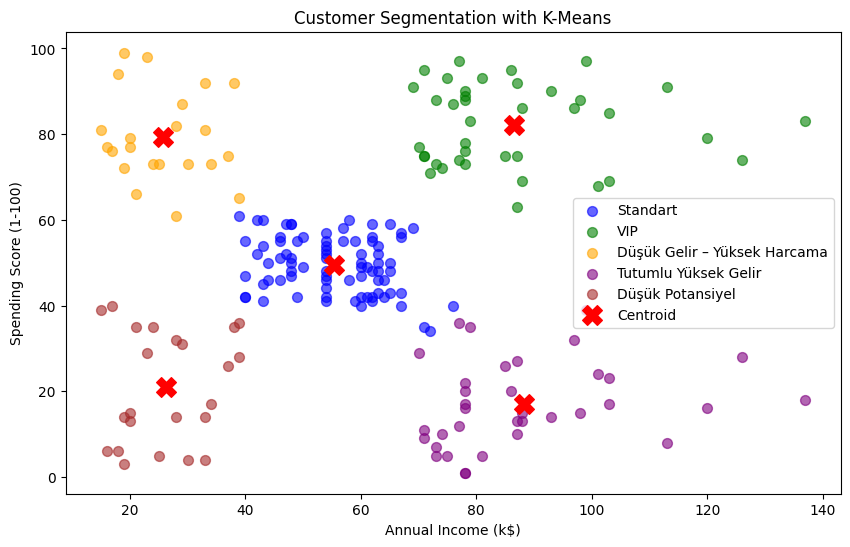

In [11]:
import matplotlib.pyplot as plt

# Segment isimlerini tanımlıyoruz
segment_names = {
    0: "Standart",
    1: "VIP",
    2: "Düşük Gelir – Yüksek Harcama",
    3: "Tutumlu Yüksek Gelir",
    4: "Düşük Potansiyel"
}

# Her cluster için renkler
colors = ['blue', 'green', 'orange', 'purple', 'brown']

plt.figure(figsize=(10,6))

# Her cluster'ı ayrı ayrı çiziyoruz
for cluster_id in range(5):
    cluster_data = df[df['Cluster'] == cluster_id]
    plt.scatter(
        cluster_data['Annual Income (k$)'], 
        cluster_data['Spending Score (1-100)'], 
        s=50, alpha=0.6, 
        c=colors[cluster_id], 
        label=segment_names[cluster_id]
    )

# Centroidleri ekle
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    c='red', s=200, marker='X', label='Centroid'
)

plt.title('Customer Segmentation with K-Means')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.legend()
plt.show()

## 🧠 Model Varsayımları ve Sınırlamaları

- K-Means algoritması, kümelerin küresel (spherical) yapıda olduğunu varsayar.
- Kümeleme yalnızca yıllık gelir ve harcama skoru değişkenleri kullanılarak yapılmıştır.
- Yaş ve cinsiyet değişkenleri analize doğrudan dahil edilmemiştir.
- Küme sayısı Elbow ve Silhouette yöntemleriyle belirlenmiştir; farklı k değerleri
  alternatif segmentasyon sonuçları üretebilir.
- Algoritma başlangıç merkezlerine duyarlı olduğundan, farklı random_state
  değerleri küçük farklılıklar oluşturabilir.

<details>
<summary><strong>Segment Bazlı Müşteri Analizi</strong></summary>

- **Standart:** Orta gelir, orta harcama düzeyi; ana müşteri kitlesini oluşturur.
- **VIP:** Yüksek gelir, yüksek harcama; en kârlı ve stratejik segmenttir.
- **Düşük Gelir – Yüksek Harcama:** Harcama eğilimi yüksek, impulsif müşteri profili.
- **Tutumlu Yüksek Gelir:** Gelir seviyesi yüksek olmasına rağmen harcama düzeyi düşüktür; potansiyel barındırır.
- **Düşük Potansiyel:** Düşük gelir ve düşük harcama; öncelikli hedef segment değildir.

</details>

## 🎯 İş Aksiyonları ve Stratejik Öneriler

- **VIP Segmenti:** Sadakat programları, özel kampanyalar ve kişiselleştirilmiş
  hizmetler ile elde tutulmalıdır. Banka kârlılığı açısından öncelikli segmenttir.

- **Tutumlu Yüksek Gelir:** Harcama potansiyeli yüksek olup,
  çapraz satış ve hedefli pazarlama kampanyaları ile aktive edilebilir.

- **Düşük Gelir – Yüksek Harcama:** Riskli müşteri profili barındırabileceğinden,
  kredi limitleri ve risk politikaları dikkatle yönetilmelidir.

- **Standart Segment:** Ana müşteri kitlesi olup,
  dengeli kampanyalar ve ürün çeşitliliği ile korunmalıdır.

- **Düşük Potansiyel:** Pazarlama maliyetleri minimize edilmeli,
  kaynaklar daha kârlı segmentlere yönlendirilmelidir.

## 🧾 Yönetici Özeti (Executive Summary)

Bu çalışma kapsamında müşteriler,
yıllık gelir ve harcama skorlarına göre K-Means algoritması ile
5 farklı segmente ayrılmıştır.

Elde edilen segmentler,
müşteri davranışlarının heterojen yapısını ortaya koymakta ve
kurumun pazarlama, satış ve risk yönetimi stratejilerine
doğrudan girdi sağlamaktadır.

Analiz sonuçları, yüksek gelir–yüksek harcama segmentinin
kurum açısından en kârlı grup olduğunu,
bazı yüksek gelirli müşterilerin ise harcama açısından
henüz yeterince aktive edilmediğini göstermektedir.

Bu segmentasyon yaklaşımı,
müşteri odaklı stratejik karar alma süreçlerinde
etkili bir analitik araç olarak kullanılabilir.